# Clustering

In [80]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, TSNE
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Preprocessing

In [11]:
df = pd.read_csv("./../../data/goodreads_data.csv", converters={"genres": lambda x: x[1:-1].split(",")})
df["publication_date"] = pd.to_datetime(df["published"].apply(lambda x: " ".join(str(x).split()[:3])), errors="coerce")
df["publication_year"] = df["publication_date"].dt.year.astype("float")
df["n_pages"] = df["pages_format"].apply(lambda x: int(x.split()[0]) if x.split()[0].isdigit() else np.nan).astype("float")
df["format"] = df["pages_format"].apply(lambda x: x.replace("Kindle Edition", "Kindle").split()[-1].lower() if x.replace("Kindle Edition", "Kindle").split()[-1].lower() in ["hardcover", "paperback", "ebook", "audiobook", "audio", "cd", "kindle"] else "other").astype("category")

dic_rating = {1: "one_star", 2: "two_stars", 3: "three_stars", 4: "four_stars", 5: "five_stars"}
for key, value in dic_rating.items():
    df[value] = df["ratings"].apply(lambda x: float(x[1:-1].split(",")[key-1])) / df["n_ratings"]
df["average_rating"] = df["ratings"].apply(lambda x: sum([(i+1) * float(x[1:-1].split(",")[i]) for i in range(5)])) / df["n_ratings"]

df.head(5)

,title,author,price,description,author_description,genres,n_ratings,n_reviews,ratings,pages_format,...,setting,publication_date,publication_year,n_pages,one_star,two_stars,three_stars,four_stars,five_stars,average_rating
0,The Weed That Strings the Hangman's Bag,Alan Bradley,4.99,From Dagger Award-winning and internationally ...,Librarian Note: There is more than one author ...,"['Mystery', 'Fiction', 'Historical Fiction',...",55692.0,5756.0,"[395.0, 1540.0, 12237.0, 25714.0, 15806.0]","364 pages, Hardcover",...,NaN,2010-03-09,2010.0,364.0,0.007093,0.027652,0.219726,0.461718,0.283811,3.987503
1,A Good Man in Africa,William Boyd,11.99,"In the small African republic of Kinjanja, Bri...","Note: William^^BoydOf Scottish descent, Boyd w...","['Fiction', 'Africa', 'Humor', 'Novels', '...",5018.0,298.0,"[90.0, 257.0, 1222.0, 2184.0, 1265.0]","352 pages, Paperback",...,['Kinjanja'],2003-01-14,2003.0,352.0,0.017935,0.051216,0.243523,0.435233,0.252092,3.852332
2,It Had to Be You,Janice Thompson,0.00,Bella couldn't be happier that her long-feudin...,"Welcome to the wacky, wonderful world of inspi...","['Christian Fiction', 'Romance', 'Christian'...",2152.0,132.0,"[14.0, 86.0, 421.0, 735.0, 896.0]","336 pages, Paperback",...,"['Galveston, Texas']",2010-05-01,2010.0,336.0,0.006506,0.039963,0.195632,0.341543,0.416357,4.121283
3,Missing,Kelley Armstrong,6.99,Everyone knows they left. No one knows they're...,Kelley Armstrong has been telling stories sinc...,"['Young Adult', 'Mystery', 'Thriller', 'Fic...",3393.0,491.0,"[54.0, 185.0, 799.0, 1308.0, 1047.0]","515 pages, ebook",...,NaN,2017-04-18,2017.0,515.0,0.015915,0.054524,0.235485,0.385500,0.308576,3.916298
4,Dawn of Rebellion,Michelle Lynn,0.00,"My name is Dawn Nolan, and I've grown up on th...",Michelle moved around the Midwest most of her ...,"['Young Adult', 'Dystopia', 'Romance', 'Sci...",142.0,76.0,"[1.0, 6.0, 23.0, 41.0, 71.0]","321 pages, Paperback",...,NaN,2013-10-17,2013.0,321.0,0.007042,0.042254,0.161972,0.288732,0.500000,4.232394


In [12]:
print("Number of books (with duplicates): ", len(df))
df.drop_duplicates(subset=["title", "author"], keep='first', inplace=True, ignore_index=True)
print("Number of books (without duplicates): ", len(df))

Number of books (with duplicates):  24630
Number of books (without duplicates):  19666


## Encoding the Qualitative Features

In [13]:
df_genres = df.explode("genres")
df_genres["genres"] = df_genres["genres"].apply(lambda x: x.strip()[1:-1]) 
df_genres["genres"].astype("category")
df_genres = df_genres[df_genres["genres"] != "...more"]

genres_groups = df_genres.groupby("genres")
genres_number_of_books = genres_groups.count().sort_values(by="title", ascending=False)
most_popular_genres = genres_number_of_books.head(10).index.tolist()

df["genres"] = df["genres"].apply(lambda x: [genre for genre in x if genre.strip()[1:-1] in most_popular_genres])
df = df[df["genres"].map(len) > 0]

In [14]:
mlb = MultiLabelBinarizer()
df_genres_one_hot = pd.DataFrame(mlb.fit_transform(df["genres"]), columns=mlb.classes_, index=df.index)

lb = LabelBinarizer()
df_format_one_hot = pd.DataFrame(lb.fit_transform(df["format"]), columns=lb.classes_, index=df.index)

df_format_one_hot.head(5)

,audio,audiobook,cd,ebook,hardcover,kindle,other,paperback
0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1


In [15]:
df_clustering = df[["price", "n_ratings", "average_rating", "publication_year", "n_pages"]]
df_clustering = (df_clustering - df_clustering.mean()) / df_clustering.std()

In [16]:
df_clustering = pd.concat([df_clustering, df_genres_one_hot, df_format_one_hot], axis=1)
df_clustering = df_clustering.dropna()

df_clustering.head(5)

,price,n_ratings,average_rating,publication_year,n_pages,'Contemporary','Fantasy','Fiction','Historical Fiction','Historical',...,'Romance','Young Adult',audio,audiobook,cd,ebook,hardcover,kindle,other,paperback
0,-0.432974,0.094743,0.003362,0.186071,0.150791,0,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0
1,0.651809,-0.156381,-0.493824,-0.482369,0.098070,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,-1.206269,-0.170584,0.495431,0.186071,0.027775,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.123036,-0.164434,-0.258542,0.854512,0.814199,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,-1.206269,-0.180545,0.904123,0.472546,-0.038126,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1


## PCA

In [17]:
# No missing value
assert(df_clustering.isna().sum().all() == 0)
# Only numeric values
assert(df_clustering.shape[1] == df_clustering.select_dtypes(include=np.number).shape[1])

In [18]:
pca = PCA()
pca = pca.fit(df_clustering)

In [19]:
cols = ['Sing. Value', 'Variance', 'Ratio', 'Cum. Sum']
cum_sum = np.array([pca.explained_variance_ratio_[:i+1].sum() for i in range(len(pca.explained_variance_ratio_))])
summary = np.array([pca.singular_values_, pca.explained_variance_, pca.explained_variance_ratio_, cum_sum]).T
df_var = pd.DataFrame(summary, columns=cols)
df_var.head(5)

,Sing. Value,Variance,Ratio,Cum. Sum
0,156.726831,1.322955,0.175988,0.175988
1,145.451580,1.139450,0.151577,0.327565
2,137.476952,1.017930,0.135412,0.462977
3,130.511292,0.917391,0.122037,0.585014
4,119.490133,0.768993,0.102297,0.687311


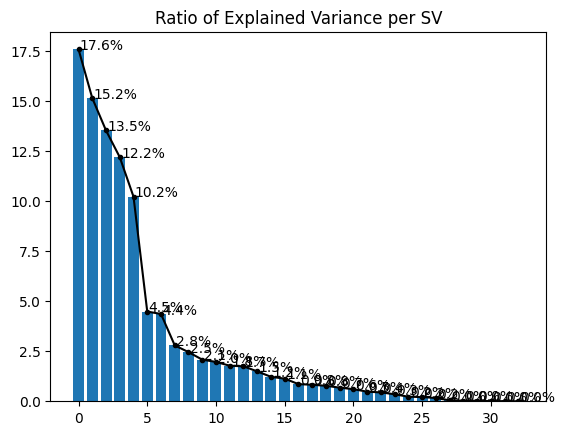

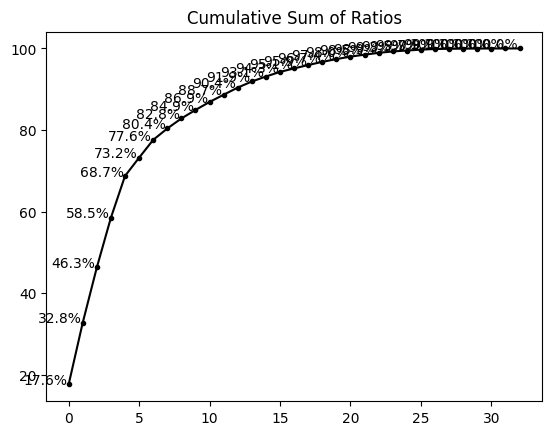

In [27]:
plt.figure()
x_axis = np.arange(0, len(pca.explained_variance_ratio_))
plt.bar(x_axis, height=pca.explained_variance_ratio_*100)
plt.plot(x_axis, pca.explained_variance_ratio_*100, marker='.', color='black')
for i in range(len(x_axis)):
    plt.text(x_axis[i] + 0.1, pca.explained_variance_ratio_[i]*100, f'{pca.explained_variance_ratio_[i]*100:.1f}%', horizontalalignment="left")
plt.title('Ratio of Explained Variance per SV')
plt.show()

plt.figure()
x2_axis = np.arange(0, len(cum_sum))
plt.plot(x2_axis, cum_sum*100, marker='.', color='black')
for i in range(len(x2_axis)):
    plt.text(x2_axis[i] - 0.1, cum_sum[i]*100, f'{cum_sum[i]*100:.1f}%', horizontalalignment="right")
plt.title('Cumulative Sum of Ratios')
plt.show()

In [30]:
n_components = 0
for i in range(len(cum_sum)):
    if cum_sum[i] >= 0.90:
        n_components = i+1
        break

print(f"Number of components to explain 90% of the variance: {n_components}")

Number of components to explain 90% of the variance: 13


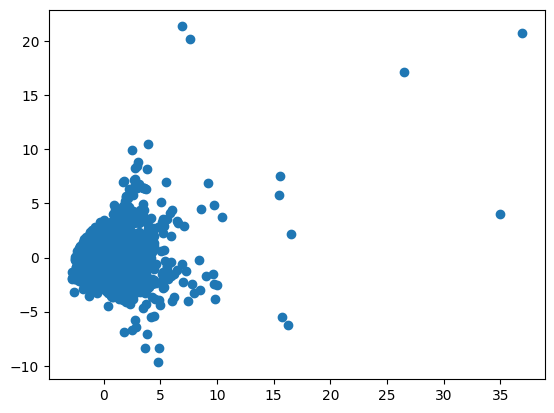

In [20]:
pca_data = pca.transform(df_clustering)
plt.scatter(pca_data[:,0], pca_data[:,1])
plt.show()

## KMeans

In [92]:
n_max_clusters = 220

In [93]:
inertias = []
silhouettes = []
for k in range(210, n_max_clusters+1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_data)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(pca_data, kmeans.labels_))

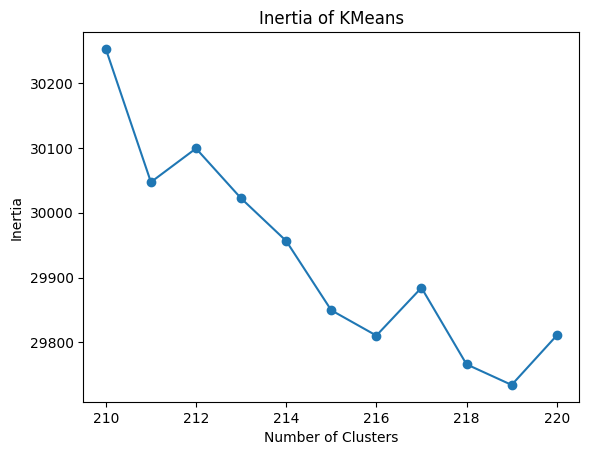

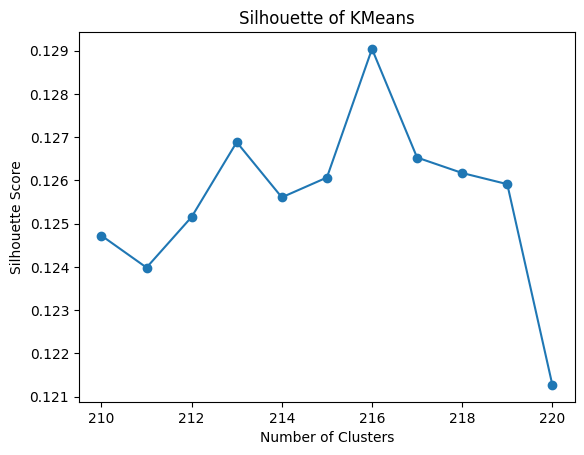

In [94]:
plt.plot(range(210, n_max_clusters+1), inertias, marker='o')
plt.title("Inertia of KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

plt.plot(range(210, n_max_clusters+1), silhouettes, marker='o')
plt.title("Silhouette of KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

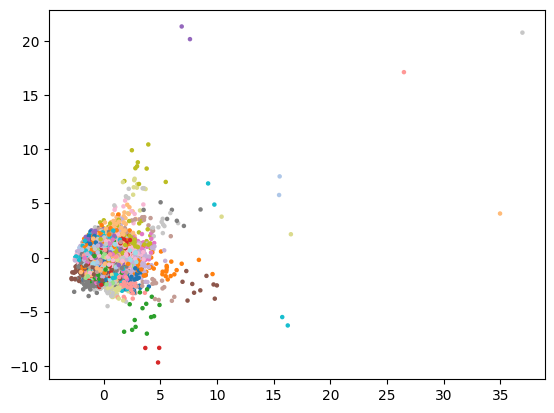

In [90]:
tab20 = plt.get_cmap('tab20')

km = KMeans(n_clusters=216)
pred = km.fit_predict(pca_data)
plt.scatter(pca_data[:,0], pca_data[:,1], color=[tab20.colors[pred[i]%20] for i in range(len(pca_data))], s=5)
plt.show()

## Isomap

C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


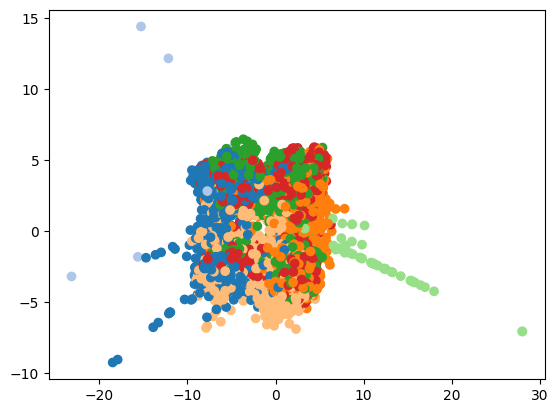

In [68]:
isomap = Isomap()
isomap_data = isomap.fit_transform(df_clustering)

km = KMeans(n_clusters=216)
pred = km.fit_predict(df_clustering)
color = [tab20.colors[pred[i]%20] for i in range(len(isomap_data))]

plt.figure()
plt.scatter(isomap_data[:,0], isomap_data[:,1], color=color)
plt.show()

## Gaussian Mixture

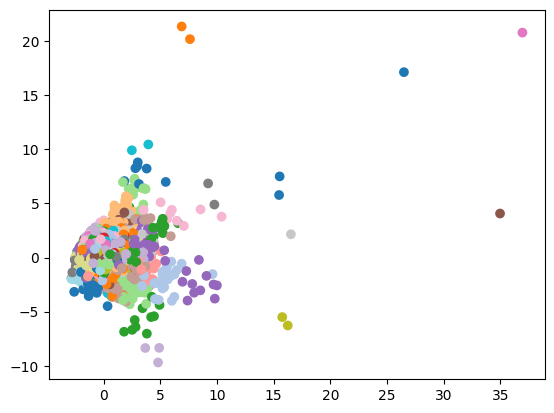

In [91]:
gmm = GaussianMixture(n_components=216)
pred = km.fit_predict(pca_data)
color = [tab20.colors[pred[i]%20] for i in range(len(isomap_data))]

plt.figure()
plt.scatter(pca_data[:,0], pca_data[:,1], color=color)
plt.show()

## Density-Based Clustering

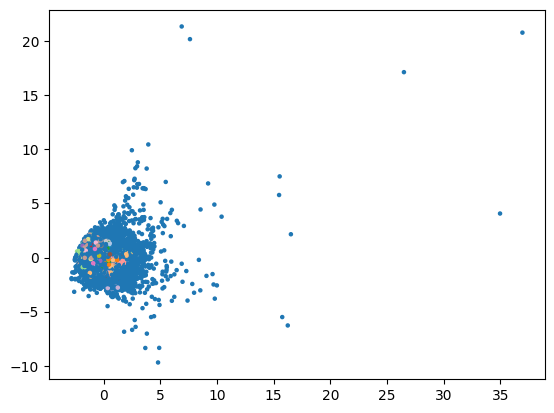

Number of components:  216


In [85]:
dbscan = DBSCAN()
pred = dbscan.fit_predict(pca_data)
color = [tab20.colors[(pred[i]+1)%20] for i in range(len(pred))]

plt.scatter(pca_data[:,0], pca_data[:,1], c=color, s=5)
plt.show()

print("Number of components: ", dbscan.labels_.max())

## MDS

In [75]:
mds = MDS()
mds_data = mds.fit_transform(df_clustering)

km = KMeans(n_clusters=216)
pred = km.fit_predict(mds_data)
color = [tab20.colors[pred[i]%20] for i in range(len(mds_data))]

plt.figure()
plt.scatter(mds_data[:,0], mds_data[:,1], color=color)
plt.show()

MemoryError: Unable to allocate 2.57 GiB for an array with shape (18568, 18568) and data type float64

## TSNE

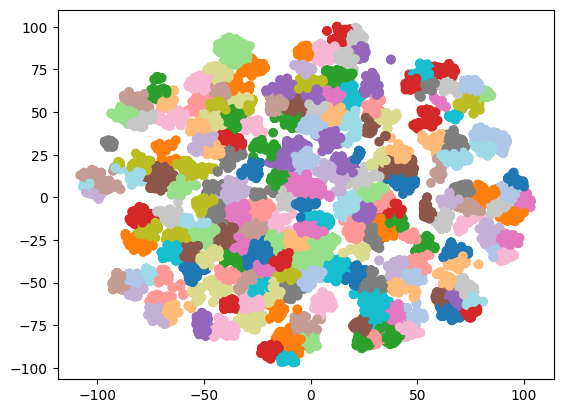

: 

In [96]:
tsne = TSNE()
tsne_data = tsne.fit_transform(df_clustering)

km = KMeans(n_clusters=216)
pred = km.fit_predict(tsne_data)
color = [tab20.colors[pred[i]%20] for i in range(len(tsne_data))]

plt.figure()
plt.scatter(tsne_data[:,0], tsne_data[:,1], color=color)
plt.show()

## Models Comparison

In [ ]:
# Silhouette Coefficient
# Davies-Bouldin Index
# T-tests -> Mean on several seeds: 1..10, 11..20, ...